# IMDb project

The main idea of this project is collect and analyze data of movies and actors from www.imdb.com
There are 3 parts described in this Report: 
1. Find distances - analyze info about actors and moves to find distances between all paies of 10 the most highest-paid actors of 2019 year.
2. Graphs - visualize graphs of distances.
3. Movie description wordcloud - Collect movie's descriptions for all movies for each of 10 the most highest-paid actors of 2019 year. Visualize WordCloud of descriptions.

## Find distances

Import nessesary libs and functions

In [125]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import csv
import networkx as nx
import matplotlib.pyplot as plt

In [126]:
def url_to_soup(url):
    headers = {'Accept-Language' : 'en'}
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, features="html.parser")
    return soup

`Current_year()` function as one of helper functions located at the imdb_helper_functions.py. This function will be used to collect only films, that have been already released 

In [127]:
def current_year():
    return datetime.now().year

The function `get_movies_by_actor_soup` return list of movies for actor. This function similar to Week 10.

In [128]:
def get_movies_by_actor_soup(actor_page_soup, num_of_movies_limit=None):
    movies = []
    this_year = current_year()
    for movie in actor_page_soup.find_all('div', class_='filmo-row'):
        if num_of_movies_limit is not None and len(movies) >= num_of_movies_limit:
            break
        if movie.find('span', class_='in_production'):
            continue
        year_column = movie.find('span', class_='year_column')
        if year_column:
            year_text = year_column.text.strip()
            if year_text.isdigit() and int(year_text) <= this_year:
                movie_text = movie.text
                if not any(keyword in movie_text for keyword in ["TV Series", "Short", "Video Game", "Video short", "Video", "TV Movie", "TV Mini-Series", "TV Series short", "TV Special"]):
                    movie_url = 'https://www.imdb.com' + movie.find('a')['href']
                    movies.append((movie.find('b').text, movie_url))
    return movies

The function `get_actors_by_movie_soup` return list of actors from movie. This function similar to Week 10.

In [129]:
def get_actors_by_movie_soup(cast_page_soup, num_of_actors_limit=None):
    actors = []
    for actor in cast_page_soup.find_all('td', class_='primary_photo'):
        if num_of_actors_limit is not None and len(actors) >= num_of_actors_limit:
            break
        actor_url = 'https://www.imdb.com' + actor.find('a')['href']
        actors.append((actor.find('img')['title'], actor_url))
    return actors

The function `get_movie_distance` get as input urls of two actors and return integer number as distance between two actors. If distance > 3 - there is no connection between two actors and function return inf.
To make faster data scrapping for several actors `get_movie_distance` collect already seen movies and actors to the `actors_for_movie_cash` and `movies_for_actor_cash` dictionaries. It leads to decrease number of requests to the IMDB.
The function first creates a BeautifulSoup object with `url_to_soup` function for each actor’s page and extracts a list of movies for each actor using the get_movies_by_actor_soup function. It then checks if the actors have appeared in the same movie, in which case the distance is 1. If not, the function continues to search for common actors between the two lists of movies, incrementing the distance each time until a common actor is found or the distance exceeds 3. If no common actor is found, the function returns infinity.

In [130]:
actors_for_movie_cash = {}
movies_for_actor_cash = {}

def get_movie_distance(actor_start_url, actor_end_url, num_of_actors_limit=None, num_of_movies_limit=None):
    actor_start_page_soup = url_to_soup(actor_start_url + 'fullcredits').find('div', class_='filmo-category-section')
    actor_start_movies = get_movies_by_actor_soup(actor_start_page_soup, num_of_movies_limit)
    actor_end_page_soup = url_to_soup(actor_end_url + 'fullcredits').find('div', class_='filmo-category-section')
    actor_end_movies = get_movies_by_actor_soup(actor_end_page_soup, num_of_movies_limit)

    if actor_start_url not in movies_for_actor_cash:
        movies_for_actor_cash[actor_start_url] = actor_start_movies
    if actor_end_url not in movies_for_actor_cash:
        movies_for_actor_cash[actor_end_url] = actor_end_movies
    current_distance = 1
    for movie in actor_start_movies:
        for movie2 in actor_end_movies:
            if movie[0] == movie2[0]:
                return int(current_distance)
    current_distance += 1
    actors_list_for_start_actor = []
    actors_list_for_end_actor = []
    # Limit of current_distance for this task is 3. Is current_distance > 3 - no connection between two actors.
    while current_distance <= 3:
        for movie in actor_start_movies:
            if movie[1] not in actors_for_movie_cash:
                actors_for_movie_cash[movie[1]] = get_actors_by_movie_soup(url_to_soup(movie[1] + 'fullcredits'), num_of_actors_limit)
            actors_list_for_start_actor += actors_for_movie_cash[movie[1]]
        for movie in actor_end_movies:
            if movie[1] not in actors_for_movie_cash:
                actors_for_movie_cash[movie[1]] = get_actors_by_movie_soup(url_to_soup(movie[1] + 'fullcredits'), num_of_actors_limit)
            actors_list_for_end_actor += actors_for_movie_cash[movie[1]]

        if actor_start_url not in actors_for_movie_cash:
            actors_for_movie_cash[actor_start_url] = actors_list_for_start_actor
        if actor_end_url not in actors_for_movie_cash:
            actors_for_movie_cash[actor_end_url] = actors_list_for_end_actor

        for actor in actors_list_for_start_actor:
            for actor2 in actors_list_for_end_actor:
                if actor[0] == actor2[0]:
                    return int(current_distance)
        current_distance += 1
    return float('inf')

The function `calculate_pairwise_distances` get as input list of actors to collect all data for different pairs of actors and return `pairwise_distances`. In this tack we will collect omly 5 top actors for each movie and 5 last movies for each actor.

In [131]:
def calculate_pairwise_distances(actors_list):
    pairwise_distances = {}
    for i, actor_start in enumerate(actors_list):
        pairwise_distances[actor_start] = {}
        for j, actor_end in enumerate(actors_list):
            if i == j:
                distance = 0
            else:
                distance = get_movie_distance(actor_start[1], actor_end[1], 5, 5)
            pairwise_distances[actor_start][actor_end] = distance
    return pairwise_distances

The function `save_pairwise_distances_to_csv` save collected distances to the CSV-file.

In [132]:
def save_pairwise_distances_to_csv(pairwise_distances, actors_list, file_path):
    with open(file_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        header_row = ['First Actor', 'First Actor Page', 'Second Actor', 'Second Actor Page', 'Distance']
        writer.writerow(header_row)
        for i, actor_start in enumerate(actors_list):
            for j, actor_end in enumerate(actors_list):
                if i != j:
                    distance = pairwise_distances[actor_start][actor_end]
                    row = [actor_start[0], actor_start[1], actor_end[0], actor_end[1], distance]
                    writer.writerow(row)

Here we run functions for the list of actors and save collected data to the CSV-file `distances.csv`.

In [136]:
actors = [
    ('Dwayne Johnson', 'https://www.imdb.com/name/nm0425005/'),
    ('Chris Hemsworth', 'https://www.imdb.com/name/nm1165110/'),
    ('Robert Downey Jr.', 'https://www.imdb.com/name/nm0000375/'),
    ('Akshay Kumar', 'https://www.imdb.com/name/nm0474774/'),
    ('Jackie Chan', 'https://www.imdb.com/name/nm0000329/'),
    ('Bradley Cooper', 'https://www.imdb.com/name/nm0177896/'),
    ('Adam Sandler', 'https://www.imdb.com/name/nm0001191/'),
    ('Scarlett Johansson', 'https://www.imdb.com/name/nm0424060/'),
    ('Sofia Vergara', 'https://www.imdb.com/name/nm0005527/'),
    ('Chris Evans', 'https://www.imdb.com/name/nm0262635/')
    ]


Next part will collect data. It's about 5 minutes.

In [137]:
pairwise_distances = calculate_pairwise_distances(actors)
csv_file_path = 'distances.csv'
save_pairwise_distances_to_csv(pairwise_distances, actors, csv_file_path)

## Graphs

In this part we will visualize collected data on graph.

In [95]:
def read_csv(filename):
    with open(filename, 'r') as file:
        reader = csv.DictReader(file)
        data = [row for row in reader]
    return data

The function `create_graph` create graph using Networkx library.

In [96]:
def create_graph(data):
    G = nx.Graph()
    for row in data:
        actor1 = row['First Actor']
        actor2 = row['Second Actor']
        distance = float(row['Distance'])
        if distance != float('inf'):
            distance = int(distance)
            G.add_edge(actor1, actor2, weight=distance)
#        else:
#            G.add_node(actor1)
#            G.add_node(actor2)
    return G

The function `wrap_text` is not realy nessesary, but make visualized graph more readable.

In [97]:
def wrap_text(text):
    words = text.split()
    lines = []
    current_line = []
    current_line_length = 0
    for word in words:
        if current_line_length + len(word) + 1 > 10:
            lines.append(' '.join(current_line))
            current_line = []
            current_line_length = 0
        current_line.append(word)
        current_line_length += len(word) + 1
    lines.append(' '.join(current_line))
    return '\n'.join(lines)

The function `draw_graph` use spring_layout from networkx and specify visualization of the graph. Edges colored with different colors: 1 - red, 2 - green, 3 - blue. This function show and save graphs.

In [100]:
def draw_graph(G):
    pos = nx.spring_layout(G)
    labels = {node: wrap_text(node) for node in G.nodes}
    nx.draw(G, pos, labels=labels, node_size=2000, node_color='skyblue', font_size=8)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    colors = ['red', 'green', 'blue']
    for distance in range(0, 3):
        edges = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] == distance]
        nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=colors[distance-1])
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title('Graph Movie Distance', fontsize=14)
    plt.axis('off')
    # save figure to the Graphs folder
    plt.savefig('Graphs/Graph.png')
    plt.show()


Here we are show the graph. Note that we show $only$ $nodes$ $with$ $connections$. If you would like show all nodes you need uncomment last 3 lines on the function `create_graph`.

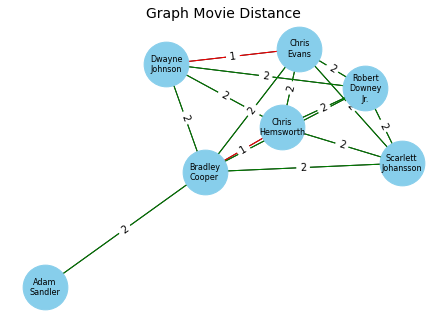

In [102]:
data = read_csv('distances.csv')
G = create_graph(data)
draw_graph(G)

Here we are show the graphs per distances.

In [93]:
def create_graph(data, dist):
    G = nx.Graph()
    for row in data:
        actor1 = row['First Actor']
        actor2 = row['Second Actor']
        distance = float(row['Distance'])
        if distance != float('inf') and distance == dist:
            if distance == dist:
                distance = int(distance)
                G.add_edge(actor1, actor2, weight=dist)
    return G

def draw_graph_with_filtered_edges(G, dist):
    pos = nx.spring_layout(G)
    labels = {node: wrap_text(node) for node in G.nodes}
    nx.draw(G, pos, labels=labels, node_size=1500, node_color='skyblue', font_size=8)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    colors = ['red', 'green', 'blue']
    for distance in range(0, 3):
        edges = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] == distance]
        nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=colors[distance-1])
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(f'Graph Movie Distance - {dist}', fontsize=14)
    plt.axis('off')
    # save figure to the Graphs folder
    plt.savefig(f'Graphs/graph_with_distances_{dist}.png')
    plt.show()

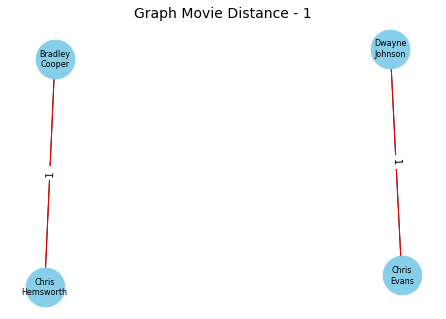

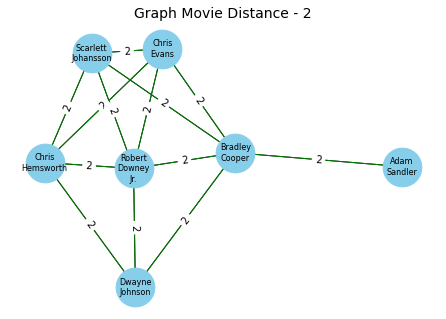

In [94]:
for i in range(1, 3):
    G = create_graph(data, i)
    draw_graph_with_filtered_edges(G, i)

## Movie description WordCloud

On this part code collect data from all movie's summary for each actor from actors list.
1. Colect all movies of actor using `get_movies_by_actor_soup`
2. For each film collect description to the list with `get_movie_descriptions_by_actor_soup` function
3. Save lists to the CSV file using `save_to_csv` function
4. Build word clouds `build_word_cloud` based on collected to CSV files using `wordcloud` library, show and save to the files figures of word clouds 


In [ ]:
pip install wordcloud --no-warn-script-location

In [ ]:
pip install --upgrade Pillow

In [176]:
import csv
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [177]:
def url_to_soup(url):
    headers = {
        'Accept-Language': 'en',
        'X-FORWARDED-FOR': '2.21.184.0',
        'User-Agent': 'Chrome/83.0.4103.116'
    }
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, features="html.parser")
    return soup

`get_movies_by_actor_soup` is the same as previosly

In [178]:
def get_movies_by_actor_soup(actor_page_soup, num_of_movies_limit=None):
    movies = []
    this_year = current_year()
    for movie in actor_page_soup.find_all('div', class_='filmo-row'):
        if num_of_movies_limit is not None and len(movies) >= num_of_movies_limit:
            break
        if movie.find('span', class_='in_production'):
            continue
        year_column = movie.find('span', class_='year_column')
        if year_column:
            year_text = year_column.text.strip()
            if year_text.isdigit() and int(year_text) <= this_year:
                movie_text = movie.text
                if not any(keyword in movie_text for keyword in ["TV Series", "Short", "Video Game", "Video short", "Video", "TV Movie", "TV Mini-Series", "TV Series short", "TV Special"]):
                    movie_url = 'https://www.imdb.com' + movie.find('a')['href']
                    movies.append((movie.find('b').text, movie_url))
    return movies

The function `get_movie_descriptions_by_actor_soup` collect descriprions from movie's page to the list `Summaries`.

In [179]:
def get_movie_descriptions_by_actor_soup(actor_page_soup):
    all_movies = get_movies_by_actor_soup(actor_page_soup)
    summaries = []
    for movie in all_movies:
        title, url = movie
        summary_url = (url+'plotsummary').replace('?', '/?')
        soup = url_to_soup(summary_url)
        summary = soup.find('div', class_='ipc-html-content-inner-div')
        if summary:
            summary = summary.text
            summaries.append((title, summary))
    return summaries

Save summaries to the text file

In [180]:
def save_to_text_file(data, filename):
    with open(filename, 'w', encoding='utf-8') as file:
        for row in data:
            file.write('\t'.join(row) + '\n')

Read from text file

In [181]:
def read_from_text_file(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        data = [row.strip().split('\t') for row in file.readlines()]  # Read all lines and split them into rows
    return data

The function `build_word_cloud` build figure using `WordCloud` library. Also the STOPWORDS was updated for several additional words to make result more precise.

In [182]:
def build_word_cloud(data, name):
    mystopwords = list(STOPWORDS) + ['one', 'two', 'ten', 'three', 'year',
                                    'at', 'ex', 'must', 'new', 'man']
    text = ' '.join([description for description in data])
    wordcloud = WordCloud(width=800, height=800,
                            background_color='white',
                            stopwords=mystopwords,
                            min_font_size=10).generate(text)

    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    # save figure to the folder Word_Clouds
    plt.savefig(f"Word_Clouds/Word_cloud_{name.replace(' ', '_')}.png")
    plt.show()

List `actors` contain 10 the most highest-paid actors of 2019 year.

In [183]:
actors = [
    ('Dwayne Johnson', 'https://www.imdb.com/name/nm0425005/'),
    ('Chris Hemsworth', 'https://www.imdb.com/name/nm1165110/'),
    ('Robert Downey Jr.', 'https://www.imdb.com/name/nm0000375/'),
    ('Akshay Kumar', 'https://www.imdb.com/name/nm0474774/'),
    ('Jackie Chan', 'https://www.imdb.com/name/nm0000329/'),
    ('Bradley Cooper', 'https://www.imdb.com/name/nm0177896/'),
    ('Adam Sandler', 'https://www.imdb.com/name/nm0001191/'),
    ('Scarlett Johansson', 'https://www.imdb.com/name/nm0424060/'),
    ('Sofia Vergara', 'https://www.imdb.com/name/nm0005527/'),
    ('Chris Evans', 'https://www.imdb.com/name/nm0262635/')
    ]

Collect description using `get_movie_descriptions_by_actor_soup` function and save list to the TXT with `save_to_text_file` function.

In [184]:
for actor in actors:
    name, url = actor
    actor_page_soup = url_to_soup(url + 'fullcredits').find('div', class_='filmo-category-section')
    descriptions = get_movie_descriptions_by_actor_soup(actor_page_soup)
    filename = f"movie_descriptions_{name.replace(' ', '_')}.txt"
    save_to_text_file(descriptions, filename)

Read descriptions from TXT, build and show figures using `build_word_cloud` function.

Word cloud for Dwayne Johnson:


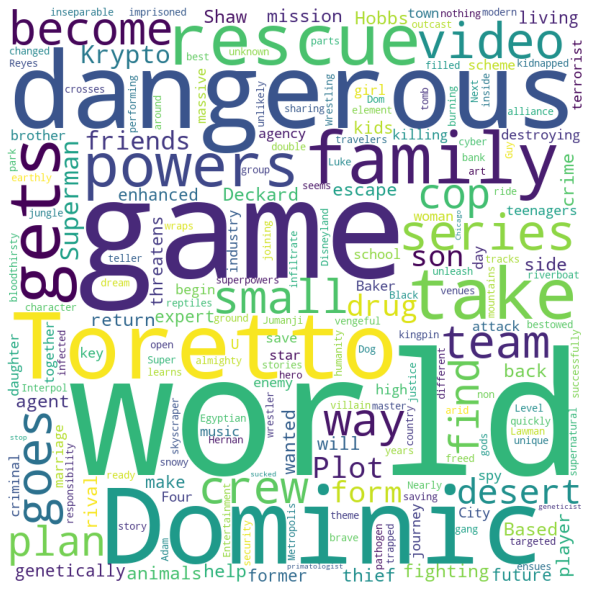

Word cloud for Chris Hemsworth:


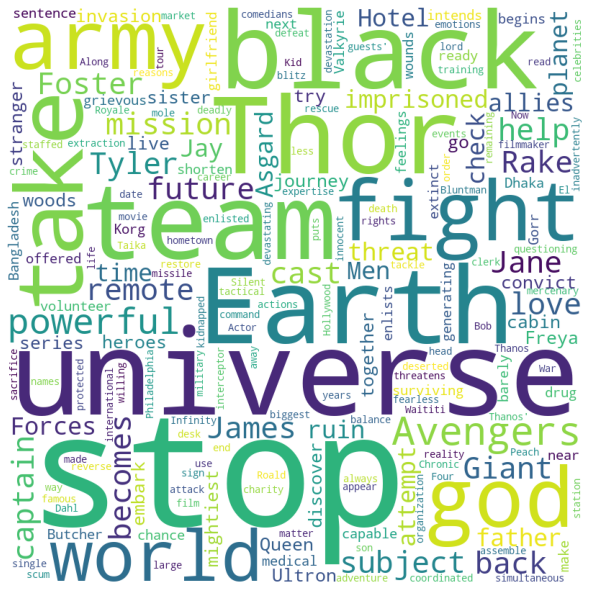

Word cloud for Robert Downey Jr.:


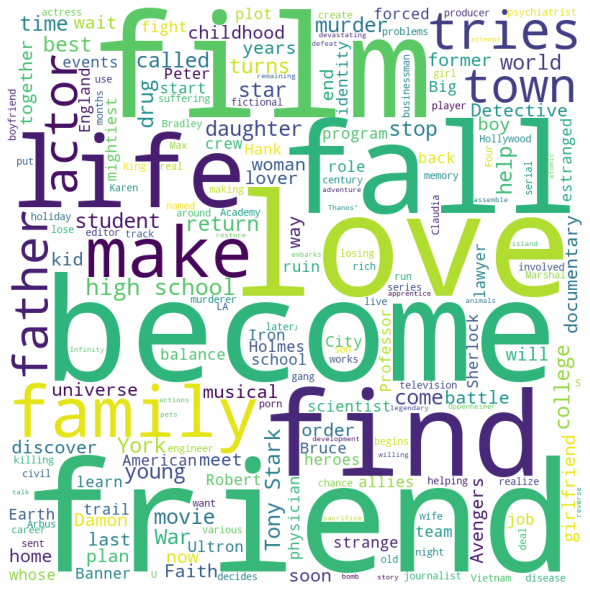

Word cloud for Akshay Kumar:


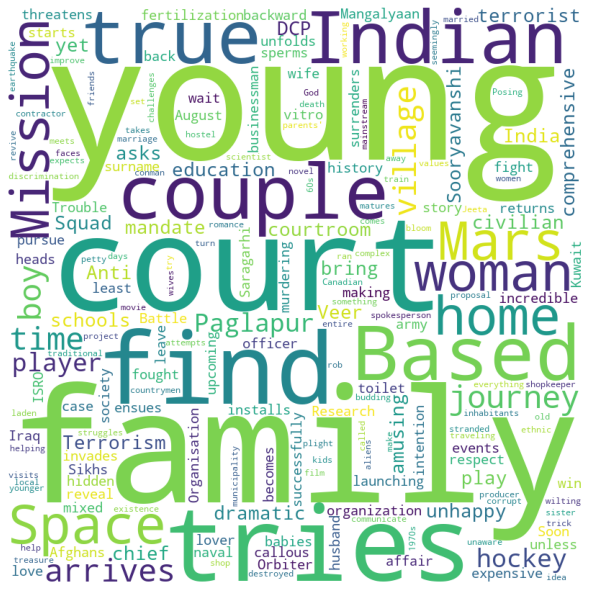

Word cloud for Jackie Chan:


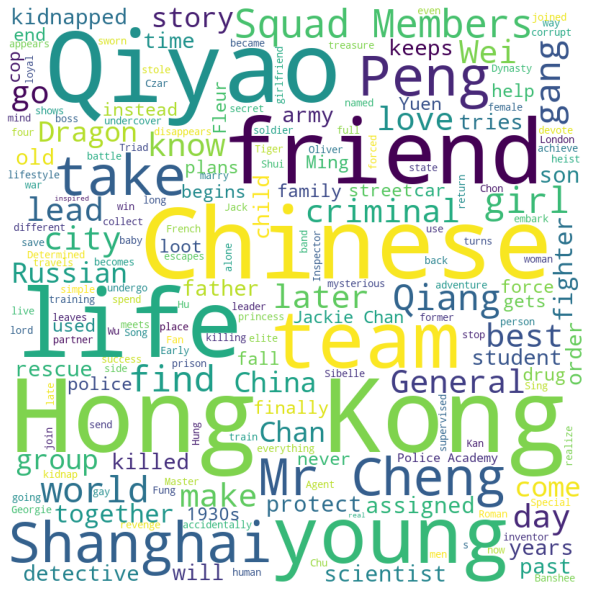

Word cloud for Bradley Cooper:


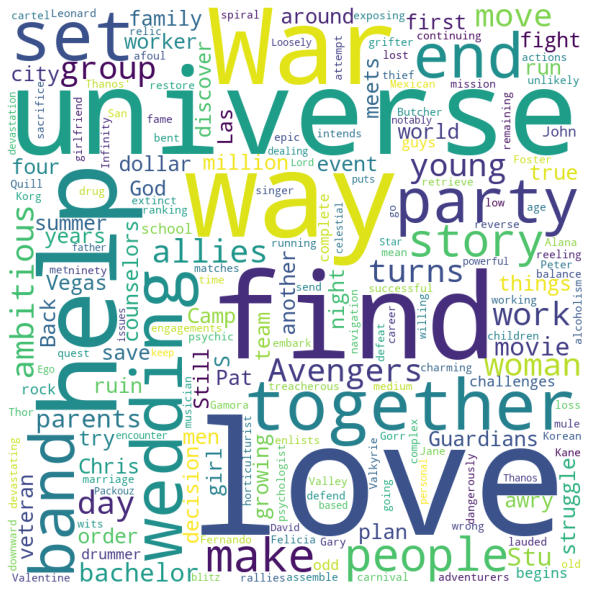

Word cloud for Adam Sandler:


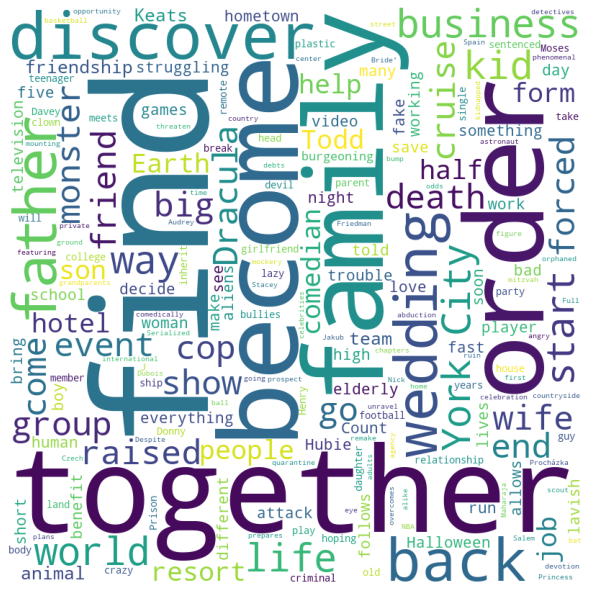

Word cloud for Scarlett Johansson:


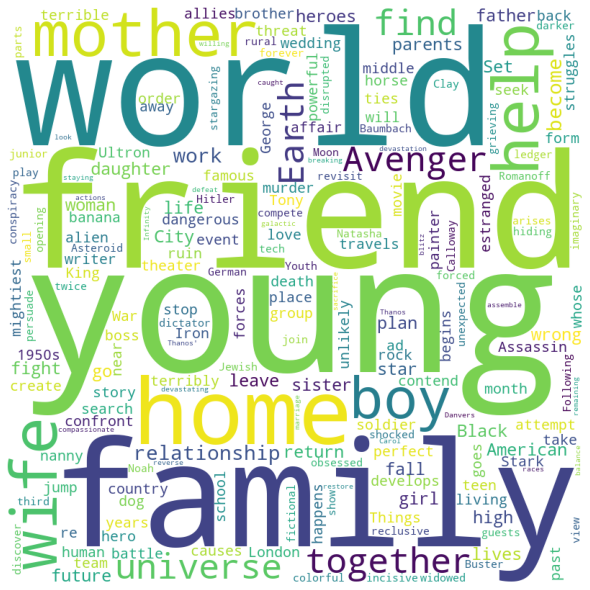

Word cloud for Sofia Vergara:


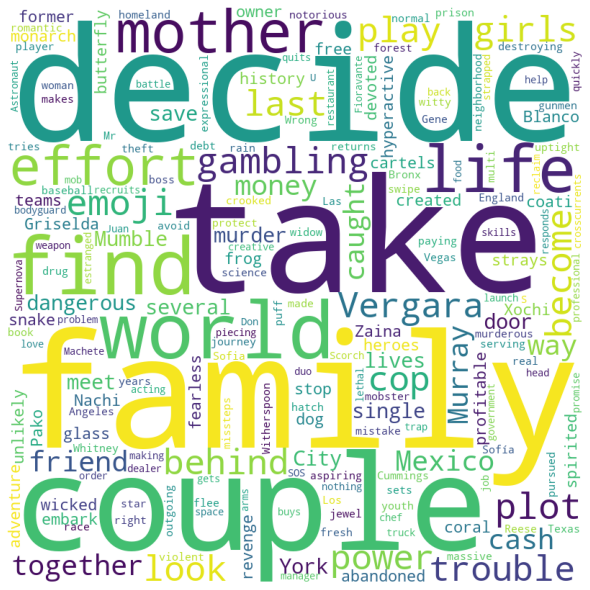

Word cloud for Chris Evans:


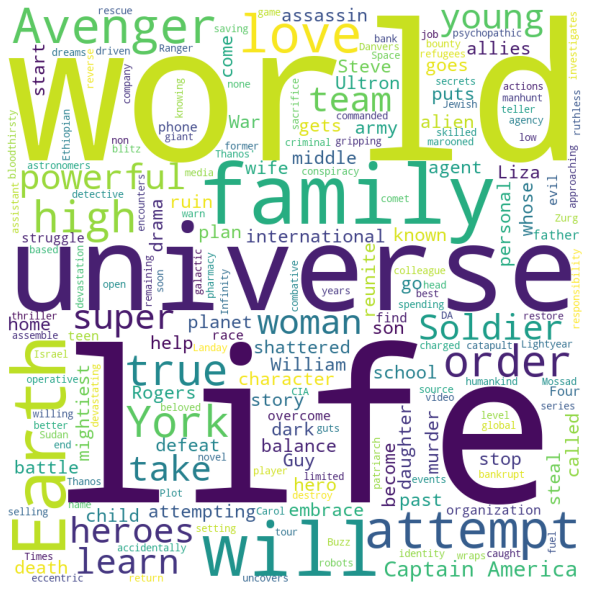

In [187]:
for actor in actors:
    name, url = actor
    filename = f"movie_descriptions_{name.replace(' ', '_')}.txt"
    descriptions = read_from_text_file(filename)
    descriptions = [description for title, description in descriptions]
    print(f"Word cloud for {name}:")
    build_word_cloud(descriptions, name)

## Conclusions

In this task are realized functions that scrape data about movies and actors from IMDB.com website.

`get_movies_by_actor_soup` scrape the full feature films list for the actor. Also, it has the option num_of_movies_limit, which is limit number of returned movies. Num_of_movies_limit is equal to 0 by default. 

`get_actors_by_movie_soup` takes in a BeautifulSoup object cast_page_soup representing the cast page of a movie on IMDb and an optional argument num_of_actors_limit. The function returns a list of names and URLs of actors in the movie.

`get_movie_distance` takes in two actor URLs, actor_start_url and actor_end_url, and optional arguments num_of_actors_limit and num_of_movies_limit. The function appears to calculate the “distance” between two actors based on the movies they have appeared in.

`get_movie_descriptions_by_actor_soup takes` takes BeautifulSoup object `actor_page_soup` representing an actor’s page on IMDb. The function returns a list of titles and summaries of movies the actor has appeared in.

Also, saveral helper functions are realized for:
presice collect data - `url_to_soup`, 
prepare data, save to CSV and read them - `calculate_pairwise_distances`, `save_pairwise_distances_to_csv`, `read_csv`, `save_to_text_file`, `read_from_text_file`
plot and visualize graphs - `draw_graph`, `wrap_text`, `create graph`, `draw_graph_with_filtered_edges`
plot and visualized wordclouds - `build_word_cloud`

All of this functions scrape data from IMDB.com website. As result it save `distances.csv`, `movie_descriptions_{actor name}.txt`, graphs per disctaces and onу joint graph into the `Graphs` folder, figures of WordClouds per actors with name `Word_cloud_{actor name}.png` into the `Word_Clouds` folder